In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=57657b2b9d0a961d8d9dd1a66f73188af88b1e197463a16ce0721620b5abbad1
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import os
import wget
import zipfile
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

In [5]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transforms = T.Compose([T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)])

train_dataset_images = datasets.CelebA(data_root, split="train", target_type=["attr", "landmarks"])
train_dataset = datasets.CelebA(data_root, split="train", target_type=["attr", "landmarks"], transform=transforms)

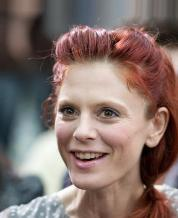

In [6]:
train_dataset_images[1][0]

In [7]:
train_data_loader = DataLoader(train_dataset, batch_size, shuffle=True, pin_memory=True)

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)

In [9]:
device = get_default_device()
train_data_loader = DeviceDataLoader(train_data_loader, device)

In [43]:
#Useful Functions
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, i, nmax=64):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images[i].detach()[:nmax]), nrow=8).permute(1, 2, 0))

def save_checkpoint(state, filename="/content/drive/MyDrive/Saved_models/celebface_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, gen_state_dict, dis_state_dict, opt_g, opt_d):
    print("=> Loading checkpoint")
    generator.load_state_dict(checkpoint["gen_state_dict"])
    discriminator.load_state_dict(checkpoint["dis_state_dict"])
    opt_g.load_state_dict(checkpoint["opt_g"])
    opt_d.load_state_dict(checkpoint["opt_d"])

In [11]:
input_length = 100
generator = nn.Sequential(

    nn.ConvTranspose2d(input_length, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)
generator = to_device(generator, device)

In [12]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [13]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()

  real_preds = discriminator(real_images)
  real_targets = torch.ones(batch_size, 1, device= device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  input = torch.randn(batch_size, input_length, 1, 1, device=device)
  fake_images = generator(input)

  fake_preds = discriminator(fake_images)
  fake_targets = torch.zeros(batch_size, 1 , device= device)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = fake_loss + real_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

discriminator = to_device(discriminator, device)

In [18]:
def train_generator(opt_g):
  opt_g.zero_grad()

  input = torch.randn(batch_size, input_length, 1, 1, device = device)
  fake_images = generator(input)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device= device)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step()

  return loss.item()

In [30]:
def train(epochs, lr, start_idx=1, load_model = True):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  if load_model:
    load_checkpoint(torch.load('/content/drive/MyDrive/Saved_models/celebface_checkpoint.pth.tar'), generator, discriminator, opt_g, opt_d)

  checkpoint = {"gen_state_dict": generator.state_dict(),"dis_state_dict": discriminator.state_dict(),"opt_g": opt_g.state_dict(),"opt_d": opt_d.state_dict()}

  for epoch in range(epochs):

    if epoch % 3 == 0:
      save_checkpoint(checkpoint)

    for i, real_images in enumerate(tqdm(train_data_loader)):
      if i%3==0:
        loss_d, real_score, fake_score = train_discriminator(real_images[0], opt_d)
      loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print(
        'Epoch = '+str(epoch),
        'loss_g = '+str(loss_g),
        'loss_d = '+str(loss_d),
        'real_score = '+str(real_score),
        'fake_score = '+str(fake_score),
    )

In [122]:
train(epochs=2, lr=0.0001, load_model = True)

=> Loading checkpoint
=> Saving checkpoint


  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch = 0 loss_g = 3.167152166366577 loss_d = 0.2903859615325928 real_score = 0.8811561465263367 fake_score = 0.13670051097869873


  0%|          | 0/2544 [00:00<?, ?it/s]

Epoch = 1 loss_g = 3.0546822547912598 loss_d = 0.22368311882019043 real_score = 0.9472025632858276 fake_score = 0.1442946046590805


torch.Size([64, 3, 64, 64])


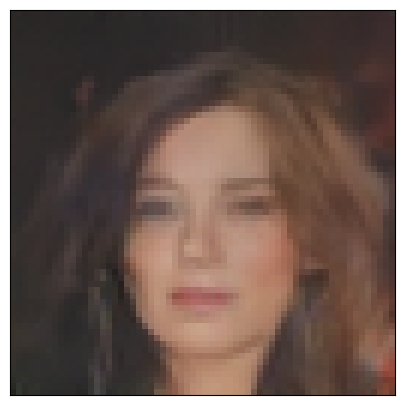

In [135]:
xb = torch.randn(batch_size, input_length, 1, 1).to(device)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu(), 3)

In [136]:
torch.save({
     'gen_state_dict': generator.state_dict(),
     'dis_state_dict': discriminator.state_dict(),
     }, '/content/drive/MyDrive/Models/celebface_checkpoint.pth.tar')